# Element based 1D HideNN-FEM - ADAM training

$\forall v\in V(\Omega), $ find $u\in H(\Omega)$,


$$\int_\Omega \nabla v \cdot \lambda(x) \nabla u = \int_\Omega f v  + \int_{\partial \Omega_N} g v$$

In [119]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

## Space interpolation (legacy)

We recode 1D shape functions in HideNN-FEM (first order).


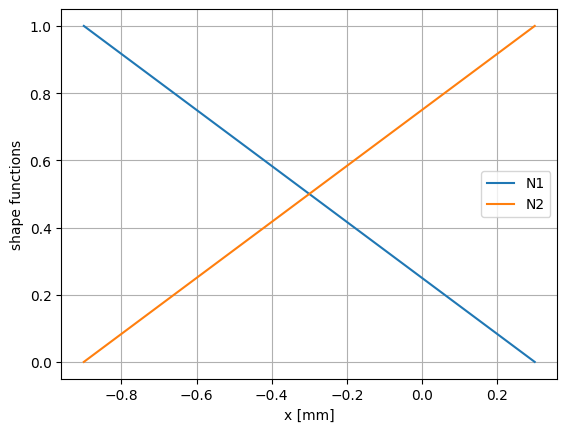

In [120]:
class mySF1D_elementBased(nn.Module):    
    def __init__(self, left = -1.,  right = 1.):
        super().__init__()        
        
        self.left   = left
        self.right  = right

        # To easily transfer to CUDA or change dtype of whole model
        self.register_buffer('one', torch.tensor([1], dtype=torch.float32))

    def forward(self, x=None, training=False):  
        if training : x = (self.left + self.right) / torch.tensor(2., requires_grad=True) 
        sf1 = - (x - self.left) / (self.right - self.left) + self.one
        sf2 = (x - self.left)/(self.right - self.left)
        if training : return  sf1, sf2, self.right - self.left, x
        else : return  sf1, sf2


l, r    =  -0.9, 0.3
mySF    = mySF1D_elementBased(left = l, right = r)

XX      = torch.linspace(l,r,100)
s1, s2  = mySF(XX)
plt.plot(XX.data, s1.data,label='N1')
plt.plot(XX.data, s2.data,label='N2')
plt.grid()
plt.xlabel("x [mm]")
plt.ylabel("shape functions")
plt.legend()  
plt.show()




## Vectorised version of the Element-based implementation

We recode 1D shape functions in HideNN-FEM (first order).

A vectorised implementation enables batch processing of several points evaluation which in terns enables batch wise differentiation.

* In non-batched implementation

    * `du_dx = [torch.autograd.grad(u[i], x[i], grad_outputs=torch.ones_like(u[i]), create_graph=True) for i,_ in enumerate(u)`

* With the batched version
    * `du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True) `


In [121]:
class mySF1D_elementBased_vectorised(nn.Module):
    def __init__(self, connectivity):
        super(mySF1D_elementBased_vectorised, self).__init__()
        if connectivity.dim == 1:
            connectivity = connectivity[:,None]
        self.connectivity = connectivity
        self.register_buffer('GaussPoint',self.GP())
        self.register_buffer('w_g',torch.tensor(1.0))


    def UpdateConnectivity(self,connectivity):
        self.connectivity = connectivity.astype(int)

    def GP(self):
        "Defines the position of the intergration point(s) for the given element"

        return torch.tensor([[1/2, 1/2]], requires_grad=True)                                       # a1, a2, th 2 area coordinates

    def forward(self, 
                x               : torch.Tensor  = None  , 
                cell_id         : list          = None  , 
                coordinates     : torch.Tensor  = None  , 
                flag_training   : bool          = False):

        assert coordinates is not None, "No nodes coordinates provided. Aborting"

        cell_nodes_IDs  = self.connectivity[cell_id,:].T
        Ids             = torch.as_tensor(cell_nodes_IDs).to(coordinates.device).t()[:,:,None]      # :,:,None] usefull only in 2+D  
        nodes_coord     = torch.gather(coordinates[:,None,:].repeat(1,2,1),0, Ids.repeat(1,1,1))    # [:,:,None] usefull only in 2+D  Ids.repeat(1,1,d) with d \in [1,3]
        
        nodes_coord = nodes_coord.to(self.GaussPoint.dtype)

        if flag_training:
            refCoordg   = self.GaussPoint.repeat(cell_id.shape[0],1)
            Ng          = refCoordg
            x_g         = torch.einsum('enx,en->ex',nodes_coord,Ng)
            refCoord    = self.GetRefCoord(x_g,nodes_coord)
            N           = refCoord
            detJ        = nodes_coord[:,1] - nodes_coord[:,0]
            return N, x_g, detJ*self.w_g

        else:
            refCoord = self.GetRefCoord(x,nodes_coord)
            N = torch.stack((refCoord[:,0], refCoord[:,1]),dim=1) 
            return N

    
    def GetRefCoord(self,x, nodes_coord):
        InverseMapping          = torch.ones([int(nodes_coord.shape[0]), 2, 2], dtype=x.dtype, device=x.device)
        detJ                    = nodes_coord[:,0,0] - nodes_coord[:,1,0]
        InverseMapping[:,0,1]   = -nodes_coord[:,1,0]
        InverseMapping[:,1,1]   = nodes_coord[:,0,0]
        InverseMapping[:,1,0]   = -1*InverseMapping[:,1,0]
        InverseMapping[:,:,:]  /= detJ[:,None,None]
        x_extended = torch.stack((x, torch.ones_like(x)),dim=1)


        return torch.einsum('eij,ej...->ei',InverseMapping,x_extended.squeeze(1))

#### Recall on the iso-parametric Finite Element Method

In 1D, for P1 elements, there are two shape functions per element, $N_1\left(\xi\right)$ and $N_2\left(\xi\right)$, $\xi \in \left[0,1\right]$ being the coordinate in the reference element space.

The iso-parametric idea relies on using the same interpolation for the space coordinates as is used for the QoIs, which means that space is interpolated using the same shape functions as the displacement is for instance.
Thus, the real space coordinate $x$ satisfies
* $x = \sum_{i=1}^{2}N_i\left(\xi \right) x_i$, 

 with $x_i$ the coordinate of the node associated with the $i-$th shape function.

 Such mapping can be expressed using the area coordinates $a_1$ and $a_2$ (such that $N_1\left(\xi\right) = a_1$ and $N_2\left(\xi\right) = a_2$).

 $\begin{pmatrix}
x \\
1
\end{pmatrix} = \underbrace{\begin{bmatrix}
x_1 & x_2\\
1 & 1
\end{bmatrix}}_{\mathcal{M}} \begin{pmatrix}
a_1 \\
a_2
\end{pmatrix}.
 $

 Reciprocally (for non degenerated elements), 

 $
 \begin{pmatrix}
a_1 \\
a_2
\end{pmatrix} = \underbrace{\frac{1}{x_1 - x_2}\begin{bmatrix}
1 & -x_2\\
-1 & x_1
\end{bmatrix}}_{\mathcal{M}^{-1}} \begin{pmatrix}
x \\
1
\end{pmatrix}.
 $

## Mesh generation

In [122]:
N           = 40
nodes       = torch.linspace(0,6.28,N)
nodes       = nodes[:,None]
elements    = torch.vstack([torch.arange(0,N-1),torch.arange(1,N)]).T

## Assembly using the vectorised element block

In [123]:
class interpolation1D(nn.Module):    
    def __init__(self, 
            nodes           : torch.Tensor  = None  , 
            elements        : list          = None  , 
            dirichlet       : list          =[0,nodes.shape[0]-1]     ,                 # Fixed nodes (by default, 2 extremities of the beam)
            n_components    : int           = 1     ):                                  # Number of dofs per node 
        super().__init__()        
        self.register_buffer('nodes', nodes)
        self.coordinates =nn.ParameterDict({
                                    'all': self.nodes,
                                    })                                                  # Should use different entries for trainable and fixed coordinates

        
        self.coordinates["all"].requires_grad   = False 
        self.n_components                       = n_components
        self.register_buffer('values',0.5*torch.ones((self.coordinates["all"].shape[0], self.n_components)))
        self.dirichlet = dirichlet

        
        self.elements = elements

        self.Ne = len(elements)

        self.shape_functions = mySF1D_elementBased_vectorised(elements)                 

        # To easily transfer to CUDA or change dtype of whole model
        self.register_buffer('one', torch.tensor([1], dtype=torch.float32))

        self.SetBCs()

    def SetBCs(self):
        assert self.n_components == 1, "only scalar field implemented. Aborting"
        if self.n_components == 1:
            self.dofs_free                  = (torch.ones_like(self.values[:])==1)[:,0]
            self.dofs_free[self.dirichlet]  = False
            


            nodal_values_imposed            = 0*self.values[~self.dofs_free,:]              # Not generic yet, only 0 BCs


            nodal_values_free               = self.values[self.dofs_free,:] 
            self.nodal_values               = nn.ParameterDict({
                                                'free'      : nodal_values_free,
                                                'imposed'   : nodal_values_imposed,
                                                })
            self.nodal_values['imposed'].requires_grad = False

    def forward(self, x = None): 
        if self.training :
            k_elt = torch.arange(0,self.Ne)
        else :
            k_elt = []
            for xx in x:
                for k in range(self.Ne):
                    elt = self.elements[k]
                    if xx >= self.coordinates["all"][elt[0]] and xx <= self.coordinates["all"][elt[1]]:
                        k_elt.append(k)
                        break
        if self.training : 
            shape_functions, x_g, detJ = self.shape_functions(
                x               = x                 , 
                cell_id         = k_elt             , 
                coordinates     = self.nodes        , 
                flag_training   = self.training     )
        else:
            shape_functions = self.shape_functions(
                x               = x                 , 
                cell_id         = k_elt             , 
                coordinates     = self.nodes        , 
                flag_training   = self.training     )
        # Batch interpolation of the solution using the computed shape functions batch
        nodal_values_tensor                     = torch.ones_like(self.values)
        nodal_values_tensor[self.dofs_free,:]   = self.nodal_values['free']
        nodal_values_tensor[~self.dofs_free,:]  = self.nodal_values['imposed']                    

        cell_nodes_IDs      = self.elements[k_elt,:].T
        Ids                 = torch.as_tensor(cell_nodes_IDs).to(nodal_values_tensor.device).t()[:,:,None]      # :,:,None] usefull only in 2+D  

        
        self.nodes_values   = torch.gather(nodal_values_tensor[:,None,:].repeat(1,2,1),0, Ids.repeat(1,1,1))    # [:,:,None] usefull only in 2+D  Ids.repeat(1,1,d) with d \in [1,3]
        self.nodes_values   = self.nodes_values.to(shape_functions.dtype)
        u = torch.einsum('gi...,gi->g',self.nodes_values,shape_functions)   

        if self.training : 

            return u, x_g, detJ
        else:
            return u


In [124]:
model = interpolation1D(nodes, elements)
model.train()
print("* Model set in training mode")

* Model set in training mode


## Training with batch version

### Supervised learning

Let's first try to learn a cosine function using supervised learning

In [125]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
MSE = nn.MSELoss()
# Training
Nepoch          = 100
lossList        = []
lossTraining    = []
model.train()
for i in range(Nepoch):
    u, x_g, detJ    = model()
    loss            = MSE(u,torch.sin(x_g)[:,0])
    optimizer.zero_grad()    
    loss.backward()          
    optimizer.step()
    lossTraining.append(loss.data)
    print(f"{i = } | loss = {loss.data :.2e}", end = "\r")

#### Post-processing

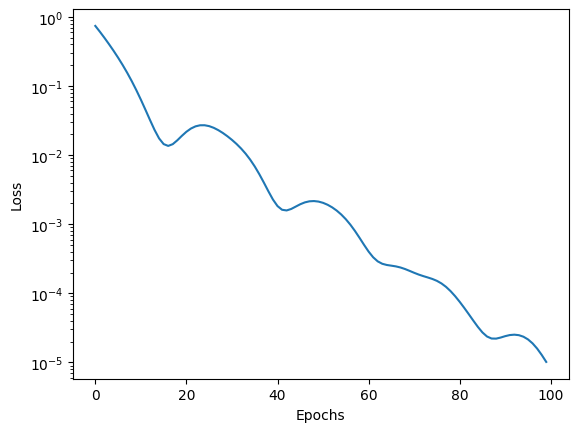

In [126]:
import matplotlib.pyplot as plt

plt.figure()
plt.semilogy(lossTraining)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

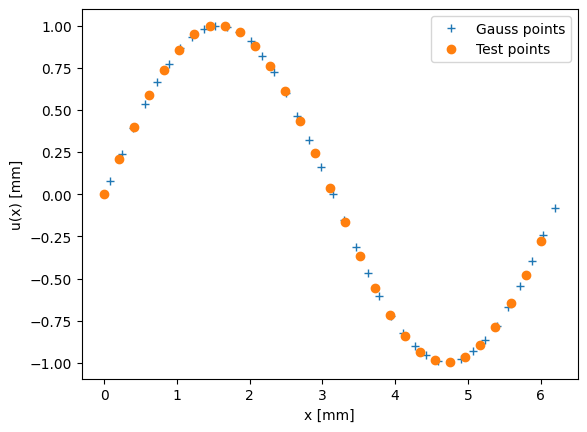

In [127]:

model.eval()

x_test = torch.linspace(0,6,30)
u_eval = model(x_test)
plt.figure()
plt.plot(x_g.data,u.data, '+',label='Gauss points')
plt.plot(x_test.data,u_eval.data, 'o',label='Test points')
plt.xlabel("x [mm]")
plt.ylabel("u(x) [mm]")
plt.legend()  
plt.show()

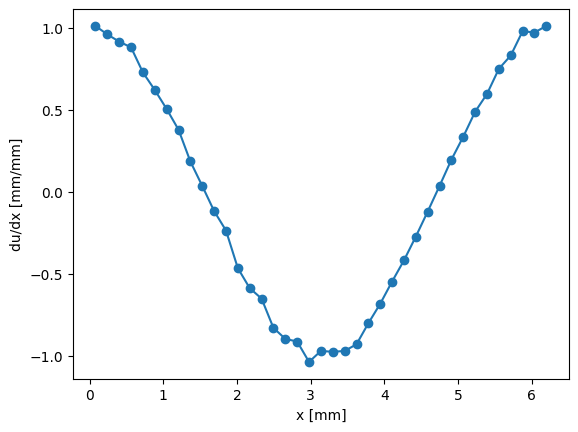

In [128]:
model.train()
u, x_g, detJ    = model()
du_dxg = torch.autograd.grad(u, x_g, grad_outputs=torch.ones_like(u), create_graph=True)[0]
plt.figure()
plt.plot(x_g.data,du_dxg.data, '-o')
plt.xlabel("x [mm]")
plt.ylabel("du/dx [mm/mm]")
plt.show()

### Unsupervised learning

Let's now try to solve a partial derivative equation (PDE) defined at the begining of this notebook.

#### Pure Adam training


In [129]:
def PotentialEnergy(u,x,f,J):
    """Computes the potential energy of the Beam, which will be used as the loss of the HiDeNN"""
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    # Vectorised calculation of the integral terms
    int_term1 =  0.5 * du_dx*du_dx * J
    int_term2 =  f(x) * J * u

    # Vectorised calculation of the integral using the trapezoidal rule
    integral = torch.sum(int_term1 - int_term2)
    return integral

def f(x):
    return 1000 #-x*(x-10)

In [130]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1)
# Training
Nepoch          = 7000
lossList        = []
lossTraining    = []
model.train()
for i in range(Nepoch):
    u, x_g, detJ    = model()
    loss            = PotentialEnergy(u,x_g,f,detJ)
    optimizer.zero_grad()    
    loss.backward()          
    optimizer.step()
    lossTraining.append(loss.data)
    print(f"{i = } | loss = {loss.data :.2e}", end = "\r")

##### Post-processing

Here the loss can be negative so a log plot is not (directly) possible

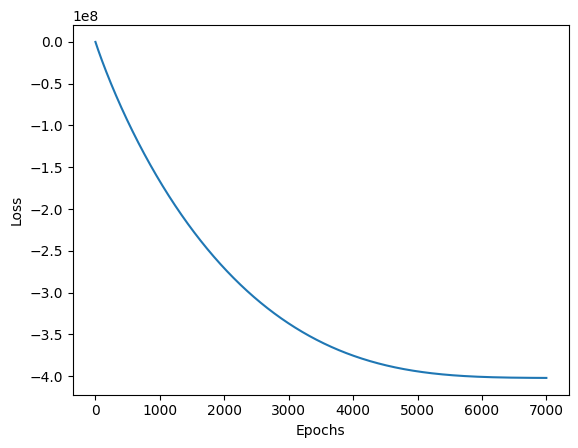

In [131]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(lossTraining)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

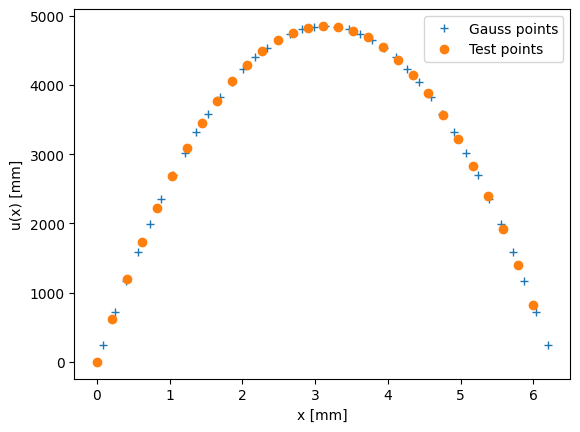

In [132]:

model.eval()

x_test = torch.linspace(0,6,30)
u_eval = model(x_test)
plt.figure()
plt.plot(x_g.data,u.data, '+',label='Gauss points')
plt.plot(x_test.data,u_eval.data, 'o',label='Test points')
plt.xlabel("x [mm]")
plt.ylabel("u(x) [mm]")
plt.legend()
plt.show() 

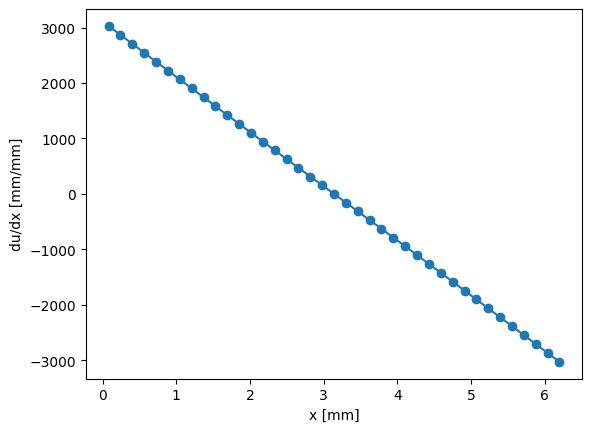

In [133]:
model.train()
u, x_g, detJ    = model()
du_dxg = torch.autograd.grad(u, x_g, grad_outputs=torch.ones_like(u), create_graph=True)[0]
plt.figure()
plt.plot(x_g.data,du_dxg.data, '-o')
plt.xlabel("x [mm]")
plt.ylabel("du/dx [mm/mm]")
plt.show()

#### Pure L-BFGS training


In [142]:
model = interpolation1D(nodes, elements)
print("* Reset model")

model.train()

optimizer = torch.optim.LBFGS(model.parameters(),
                line_search_fn="strong_wolfe")
# Training
Nepoch          = 10
lossList        = []
lossTraining    = []

def closure():
    optimizer.zero_grad()
    u, x_g, detJ    = model()
    loss            = PotentialEnergy(u,x_g,f,detJ)
    loss.backward()
    return loss

model.train()
for i in range(Nepoch):
    optimizer.step(closure)
    loss = closure()
    lossTraining.append(loss.data)
    print(f"{i = } | loss = {loss.data :.2e}", end = "\r")

* Reset model


##### Post-processing

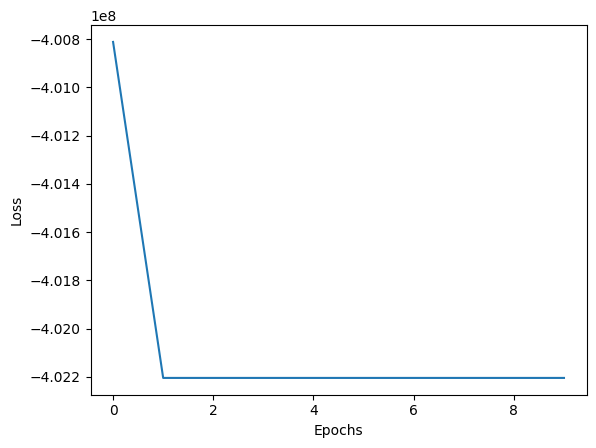

In [143]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(lossTraining)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

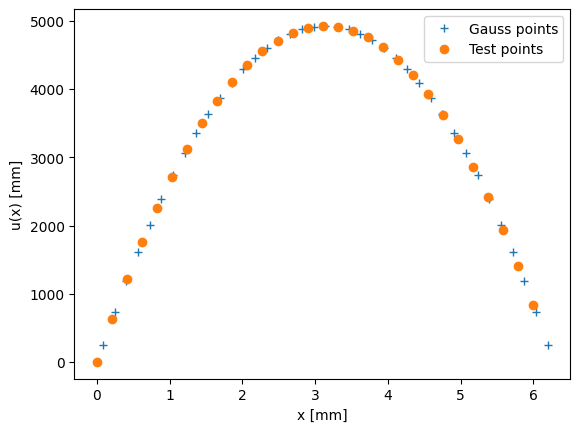

In [144]:
model.train()

u, x_g, detJ    = model()

model.eval()

x_test = torch.linspace(0,6,30)
u_eval = model(x_test)
plt.figure()
plt.plot(x_g.data,u.data, '+',label='Gauss points')
plt.plot(x_test.data,u_eval.data, 'o',label='Test points')
plt.xlabel("x [mm]")
plt.ylabel("u(x) [mm]")
plt.legend()
plt.show() 

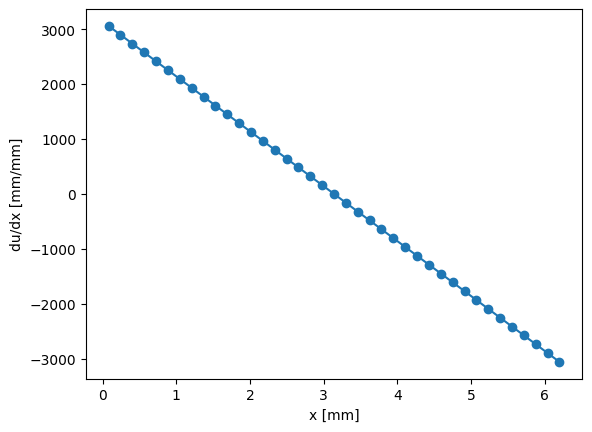

In [145]:
model.train()
u, x_g, detJ    = model()
du_dxg = torch.autograd.grad(u, x_g, grad_outputs=torch.ones_like(u), create_graph=True)[0]
plt.figure()
plt.plot(x_g.data,du_dxg.data, '-o')
plt.xlabel("x [mm]")
plt.ylabel("du/dx [mm/mm]")
plt.show()